# M4 Agentic AI - Adding a component-level eval to the research workflow

## 1. Introduction

In the previous graded lab (M3), you built a tool-using research agent that carried out a workflow of three steps:

1. Search the web for information.  
2. Reflect on its output.  
3. Publish a clear HTML report.  

Now, in this ungraded lab, you are going to focus on evaluating **one component of that workflow**: the *research step*.  

Instead of generating essays and refining them, here you will design a **component-level evaluation** to check the quality of sources returned by the research step.  

The evaluation will compare the URLs retrieved by the agent against a **predefined list of preferred domains** (e.g., `arxiv.org`, `nature.com`, `nasa.gov`).  

This allows you to quantify whether the system is pulling information from trustworthy sources, using an **objective, per-example ground truth evaluation**.


### 1.1. Lab overview

In the video, Andrew showed a case where web search results were of **poor quality**, making it difficult to trust the information retrieved.  
Building on that example, in this lab you will evaluate the reliability of sources by comparing them against a **predefined list of preferred domains**.

For this evaluation, we’ll focus on the topic *“recent developments in black hole science”*, one of the examples highlighted in the course.  
The idea is to verify whether the web search tool is returning sources from preferred domains, and to quantify the ratio of preferred vs. total results.

This evaluation will be implemented as a single function that performs an **objective, per-example check**. It will:

* Parse the Tavily output (our web search tool).  
* Identify which URLs belong to the list of **preferred domains**.  
* Compute the ratio of preferred vs. total retrieved sources.  
* Return both a boolean flag (**PASS/FAIL**) and a Markdown-formatted summary that can be embedded directly into reports.  

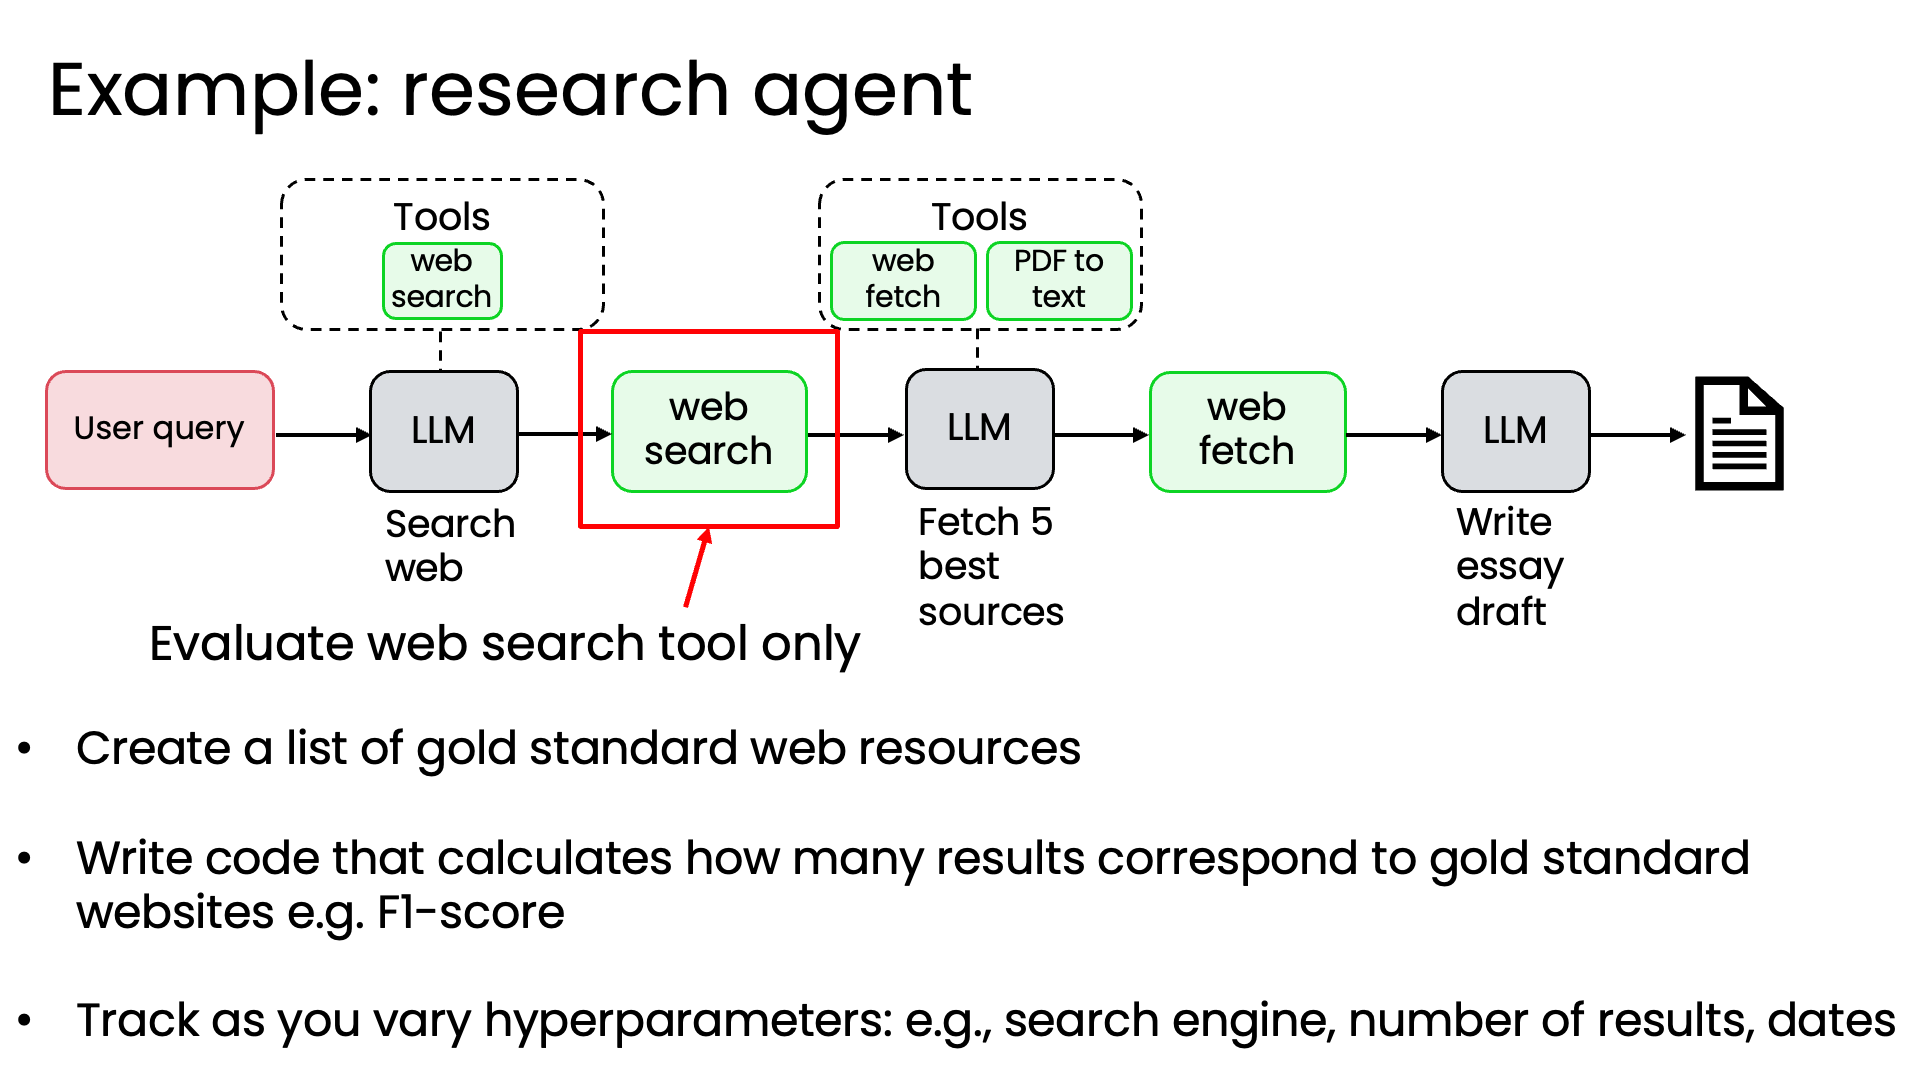


### 1.2. 🎯 Learning outcomes

You will learn how to:

* Write a function that can check the search results of a web search API for **preferred sources**.  
* Create an evaluation to verify if your sources come from your **preferred domains**.  
* Add a **component-level evaluation** to the web search function.  


## 2. Setup: Import libraries and load environment

As in previous labs, you start by importing the required libraries and initializing your environment.

In [1]:
# =========================
# Imports
# =========================

# --- Standard library 
from datetime import datetime
import json
import re

# --- Third-party ---
from aisuite import Client

# --- Local / project ---
import research_tools
import utils

client = Client()

## 3. Research Step – `find_references`

In the graded lab, the function you implemented both **searched the web and wrote a draft report** in one step.

Here, we split the web search functionality into a separate function called `find_references`. This allows you to evaluate the search results independently of the writing and reflection steps, which we will leave out from this lab since we are only focusing on the output of the web search step.

Notice two key differences from the graded lab implementation:

* This new function uses **AISuite**, which automatically manages the tool calls for you (instead of writing manual tool-calling code with the OpenAI SDK).  
* The function also informs the LLM of the **current date**, which helps improve relevance for time-sensitive queries.  

The role of `find_references` is to **gather external information** from tools such as **Arxiv**, **Tavily**, and **Wikipedia**.  
Because the quality of these results directly shapes the outputs of the graded lab, this is the stage where you can apply **evaluation methods** — for example, checking whether the returned URLs come from your list of **preferred domains**.  

In [2]:
def find_references(task: str, model: str = "openai:gpt-4o", return_messages: bool = False):
    """Perform a research task using external tools (arxiv, tavily, wikipedia)."""

    prompt = f"""
    You are a research function with access to:
    - arxiv_tool: academic papers
    - tavily_tool: general web search (return JSON when asked)
    - wikipedia_tool: encyclopedic summaries

    Task:
    {task}

    Today is {datetime.now().strftime('%Y-%m-%d')}.
    """.strip()

    messages = [{"role": "user", "content": prompt}]
    tools = [
        research_tools.arxiv_search_tool,
        research_tools.tavily_search_tool,
        research_tools.wikipedia_search_tool,
    ]

    try:
        response = client.chat.completions.create(
            model=model,
            messages=messages,
            tools=tools,
            tool_choice="auto",
            max_turns=5,
        )
        content = response.choices[0].message.content
        return (content, messages) if return_messages else content
    except Exception as e:
        return f"[Model Error: {e}]"

Run the following cell to test the research function.  
This task will retrieve two recent papers on developments in black hole science and display the results.

In [3]:
research_task = "Find 2 recent papers about recent developments in black hole science"
research_result = find_references(research_task)

utils.print_html(
    research_result,
    title="Research Function Output"
)

## 4. Evaluation Step – Preferred Domains

Not all sources retrieved by web search are equally reliable.  
In this lab, we focus on **just one step from the previous graded lab** — the `find_references` research step — and show how to design a **component-level evaluation** that checks whether the returned domains belong to a predefined list of **preferred domains**.  

This is an example of an **objective evaluation with a clear per-example ground truth**.  
As a reminder from the lecture, recall the two axes of evaluation: along these axes we are working in the **upper-left quadrant** — objective evaluations with explicitly defined ground truth applied at the level of each example.

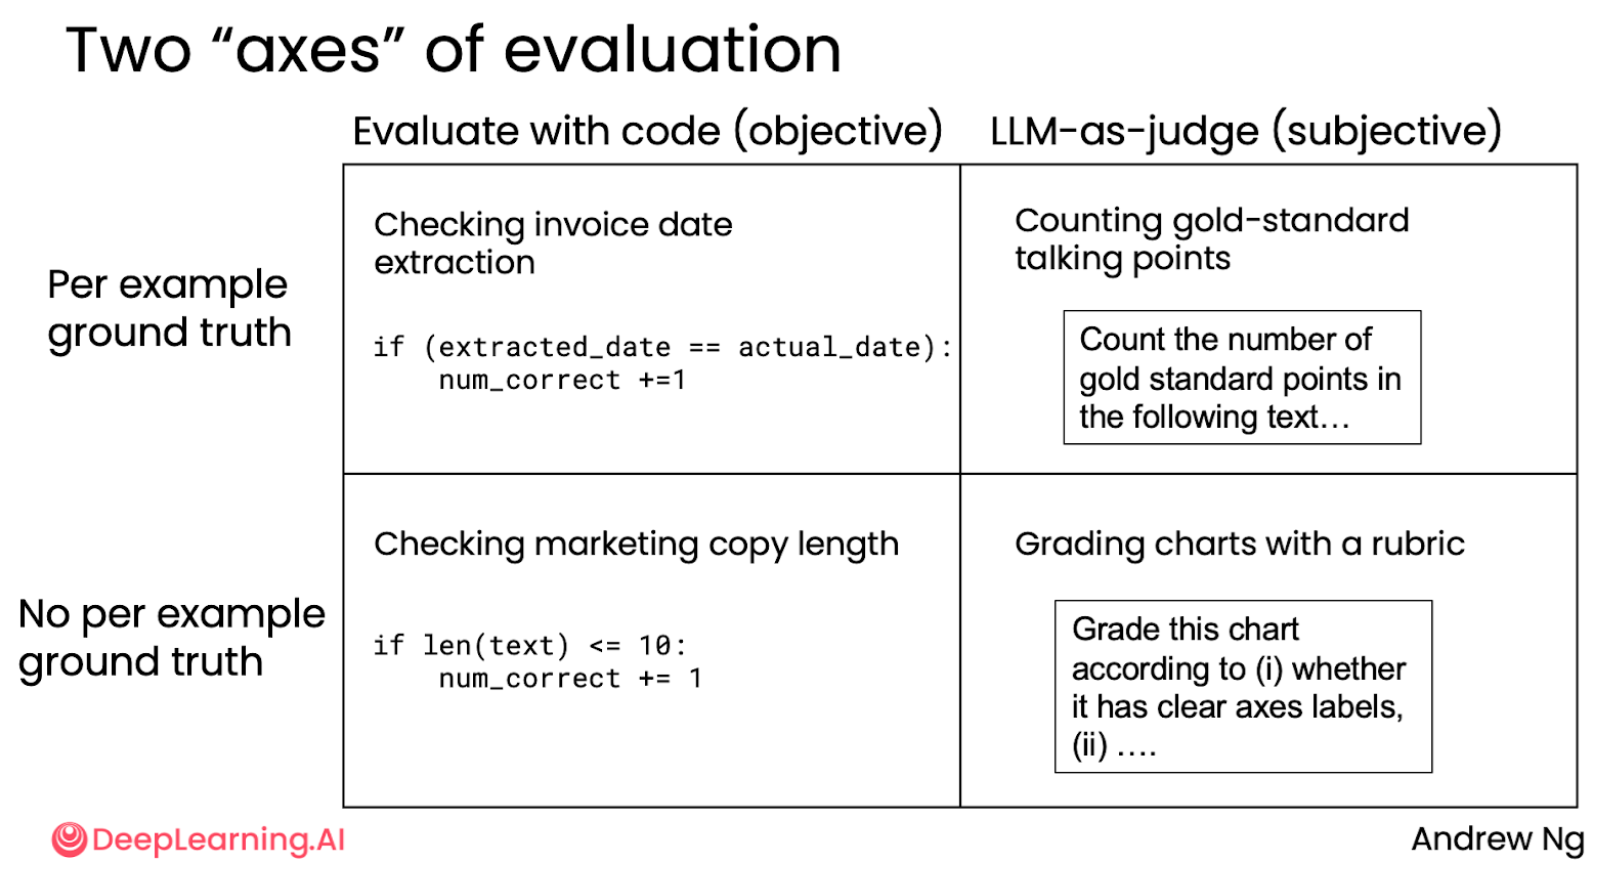


### Why component-level evaluations?

As Andrew mentioned in the lecture:  

- If the problem lies in web search (usually the **first step** in a graded lab workflow), rerunning the *entire* pipeline (search → draft → reflect) every time can be **expensive** and noisy.  
- Small improvements in web search quality may be hidden by randomness introduced by later components.  
- By evaluating the web search *alone*, you get a **clearer signal** of whether that component is improving.  

Component-level evals are also efficient when multiple teams are working on different pieces of a system: each team can optimize its own component using a clear metric, without needing to run or wait for full end-to-end tests.  

### How do we evaluate?

Our evaluation here is **objective**, and so can be evaluated using code. It has an example-specific ground truth - the list of preferred sources for this black hole query. To build the eval, you will:

1. Extract the URLs returned by Tavily.  
2. Compare them against a predefined list of **preferred domains** (e.g., `arxiv.org`, `nature.com`, `nasa.gov`).  
3. Compute the **ratio of preferred vs. total results**.  
4. Return a **PASS/FAIL flag** along with a Markdown-formatted summary.  

This provides a reproducible, low-cost metric that tells us whether the research component — and only this step from the graded lab — is pulling from trusted sources.



In [4]:
# list of preferred domains for Tavily results
TOP_DOMAINS = {
    # General reference / institutions / publishers
    "wikipedia.org", "nature.com", "science.org", "sciencemag.org", "cell.com",
    "mit.edu", "stanford.edu", "harvard.edu", "nasa.gov", "noaa.gov", "europa.eu",

    # CS/AI venues & indexes
    "arxiv.org", "acm.org", "ieee.org", "neurips.cc", "icml.cc", "openreview.net",

    # Other reputable outlets
    "elifesciences.org", "pnas.org", "jmlr.org", "springer.com", "sciencedirect.com",

    # Extra domains (case-specific additions)
    "pbs.org", "nova.edu", "nvcc.edu", "cccco.edu",

    # Well known programming sites
    "codecademy.com", "datacamp.com"
}

def evaluate_tavily_results(TOP_DOMAINS, raw: str, min_ratio=0.4):
    """
    Evaluate whether plain-text research results mostly come from preferred domains.

    Args:
        TOP_DOMAINS (set[str]): Set of preferred domains (e.g., 'arxiv.org', 'nature.com').
        raw (str): Plain text or Markdown containing URLs.
        min_ratio (float): Minimum preferred ratio required to pass (e.g., 0.4 = 40%).

    Returns:
        tuple[bool, str]: (flag, markdown_report)
            flag -> True if PASS, False if FAIL
            markdown_report -> Markdown-formatted summary of the evaluation
    """

    # Extract URLs from the text
    url_pattern = re.compile(r'https?://[^\s\]\)>\}]+', flags=re.IGNORECASE)
    urls = url_pattern.findall(raw)

    if not urls:
        return False, """### Evaluation — Tavily Preferred Domains
No URLs detected in the provided text. 
Please include links in your research results.
"""

    # Count preferred vs total
    total = len(urls)
    preferred_count = 0
    details = []

    for url in urls:
        domain = url.split("/")[2]
        preferred = any(td in domain for td in TOP_DOMAINS)
        if preferred:
            preferred_count += 1
        details.append(f"- {url} → {'✅ PREFERRED' if preferred else '❌ NOT PREFERRED'}")

    ratio = preferred_count / total if total > 0 else 0.0
    flag = ratio >= min_ratio

    # Markdown report
    report = f"""
### Evaluation — Tavily Preferred Domains
- Total results: {total}
- Preferred results: {preferred_count}
- Ratio: {ratio:.2%}
- Threshold: {min_ratio:.0%}
- Status: {"✅ PASS" if flag else "❌ FAIL"}

**Details:**
{chr(10).join(details)}
"""
    return flag, report

<div style="border:1px solid #93c5fd; border-left:6px solid #3b82f6; background:#dbeafe; border-radius:6px; padding:12px 14px; color:#1e3a8a; font-family:system-ui,-apple-system,Segoe UI,Roboto,Ubuntu,Cantarell,Noto Sans,sans-serif;">  
<strong>🔎 Why this is an objective evaluation:</strong><br><br>  
Each URL retrieved from Tavily is compared against a predefined list of <em>preferred domains</em> (<code>TOP_DOMAINS</code>):<br>  
• If the domain matches → ✅ PREFERRED<br>  
• Otherwise → ❌ NOT PREFERRED<br><br>  
This yields a clear PASS/FAIL signal depending on whether the ratio of preferred sources exceeds a given threshold.  
Because the ground truth (preferred vs. not preferred) is explicitly defined for each example, the evaluation is both <strong>objective</strong> and <strong>reproducible</strong>.  
</div>


Run the cell to display sample preferred domains, the research results, and the evaluation summary (PASS/FAIL with details).

In [5]:
utils.print_html(json.dumps(list(TOP_DOMAINS)[:4], indent=2), title="Sample Trusted Domains")

utils.print_html("<h3>Research Results</h3>" + research_result, title="Research Results")

flag, report = evaluate_tavily_results(TOP_DOMAINS, research_result)
utils.print_html("<pre>" + report + "</pre>", title="<h3>Evaluation Summary</h3>")

## Try yourself!

Now it’s your turn.  
In this section, you can experiment directly with the **research step** and its **evaluation**:  

* **Topic**: choose a different topic to research.  
* **Preferred domains**: edit or expand the `TOP_DOMAINS` list.  
* **Evaluation ratio**: adjust the `min_ratio` (e.g., 0.4 = at least 40% preferred sources).  

Re-run the cells below after making your edits to see how the evaluation changes.


In [6]:
# === 5.1. Try it yourself: topic, ratio & preferred domains ===
# Edit these parameters before running the cell

topic = "recent developments in black hole science"   # <- Change the topic here
min_ratio = 0.4                                       # <- Change threshold (0.0–1.0)
run_reflection = True                                 # <- Set False to skip Step 4

# Short list of preferred domains (edit or expand as needed)
TOP_DOMAINS = {
    "wikipedia.org", "nature.com", "science.org", "arxiv.org",
    "nasa.gov", "mit.edu", "stanford.edu", "harvard.edu"
}

# Show a sample of preferred domains
import json
utils.print_html(
    json.dumps(sorted(list(TOP_DOMAINS)), indent=2),
    title="<h3>Sample Preferred Domains</h3>"
)

# 1) Research
research_task = f"Find 2–3 key papers and reliable overviews about {topic}."
research_output = find_references(research_task)
utils.print_html(research_output, title=f"<h3>Research Results on {topic}</h3>")

# 2) Evaluate sources (preferred domains ratio)
flag, eval_md = evaluate_tavily_results(TOP_DOMAINS, research_output, min_ratio=min_ratio)
utils.print_html("<pre>" + eval_md + "</pre>", title="<h3>Evaluation Summary</h3>")

## 5. Takeaways

* You just saw how to evaluate the performance of **one component**: the `find_references` research step.  
* Your component-level evaluation checked whether the retrieved URLs were in a predefined list of **preferred domains**.  
* This is an example of an **objective evaluation** with a clear **per-example ground truth**.  
* To build an evaluation set, you could design ~10 prompts covering different topics (astronomy, robotics, finance, etc.) and define preferred domains for each.  
* The percentage of retrieved sources that matched the list of preferred domains provides a useful **metric** to guide improvements, such as adjusting the prompt or tool parameters.  
* This approach is **simpler and cheaper** than evaluating full essays with reflection and rewrites, since you only focus on the web search component.  

<div style="border:1px solid #22c55e; border-left:6px solid #16a34a; background:#dcfce7; border-radius:6px; padding:14px 16px; color:#064e3b; font-family:system-ui,-apple-system,Segoe UI,Roboto,Ubuntu,Cantarell,Noto Sans,sans-serif;">

🎉 **Congratulations!**  

You designed a **component-level evaluation** that makes your research agent more reliable.  
By directly checking the quality of sources, you introduced a safeguard that is **objective, reproducible, and cost-effective**.  

This aligns with the idea highlighted in Andrew’s lecture: *component-level evaluations* let you test individual pieces of an AI system without the overhead of evaluating the entire pipeline.  

</div>


